# LSTM

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score,
                           precision_recall_fscore_support, confusion_matrix)
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

train_data = np.load('/home/haoqian/anomaly/SMD/SMD_train.npy')
test_data = np.load('/home/haoqian/anomaly/SMD/SMD_test.npy')
test_label = np.load('/home/haoqian/anomaly/SMD/SMD_test_label.npy')

Using device: cuda


Using device: cuda


/tmp/ipykernel_1777693/2223568783.py:29: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/tmp/ipykernel_1777693/2223568783.py:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_1777693/2223568783.py:29: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/tmp/ipykernel_1777693/2223568783.py:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
Epoch 1: 100%|██████████| 11069/11069 [00:17<00:00, 638.20it/s]


Epoch 1, Loss: 0.2573


Epoch 2: 100%|██████████| 11069/11069 [00:16<00:00, 662.58it/s]


Epoch 2, Loss: 0.2194


Epoch 3: 100%|██████████| 11069/11069 [00:16<00:00, 662.80it/s]


Epoch 3, Loss: 0.2140


Epoch 4: 100%|██████████| 11069/11069 [00:16<00:00, 662.68it/s]


Epoch 4, Loss: 0.2109


Epoch 5: 100%|██████████| 11069/11069 [00:16<00:00, 662.64it/s]


Epoch 5, Loss: 0.2084


Epoch 6: 100%|██████████| 11069/11069 [00:16<00:00, 663.24it/s]


Epoch 6, Loss: 0.2065


Epoch 7: 100%|██████████| 11069/11069 [00:16<00:00, 663.15it/s]


Epoch 7, Loss: 0.2050


Epoch 8: 100%|██████████| 11069/11069 [00:16<00:00, 662.95it/s]


Epoch 8, Loss: 0.2033


Epoch 9: 100%|██████████| 11069/11069 [00:16<00:00, 661.98it/s]


Epoch 9, Loss: 0.2015


Epoch 10: 100%|██████████| 11069/11069 [00:16<00:00, 661.48it/s]


Epoch 10, Loss: 0.2004


Epoch 11: 100%|██████████| 11069/11069 [00:16<00:00, 661.08it/s]


Epoch 11, Loss: 0.1996


Epoch 12: 100%|██████████| 11069/11069 [00:16<00:00, 661.56it/s]


Epoch 12, Loss: 0.1990


Epoch 13: 100%|██████████| 11069/11069 [00:16<00:00, 662.96it/s]


Epoch 13, Loss: 0.1986


Epoch 14: 100%|██████████| 11069/11069 [00:16<00:00, 663.46it/s]


Epoch 14, Loss: 0.1982


Epoch 15: 100%|██████████| 11069/11069 [00:16<00:00, 663.90it/s]


Epoch 15, Loss: 0.1978


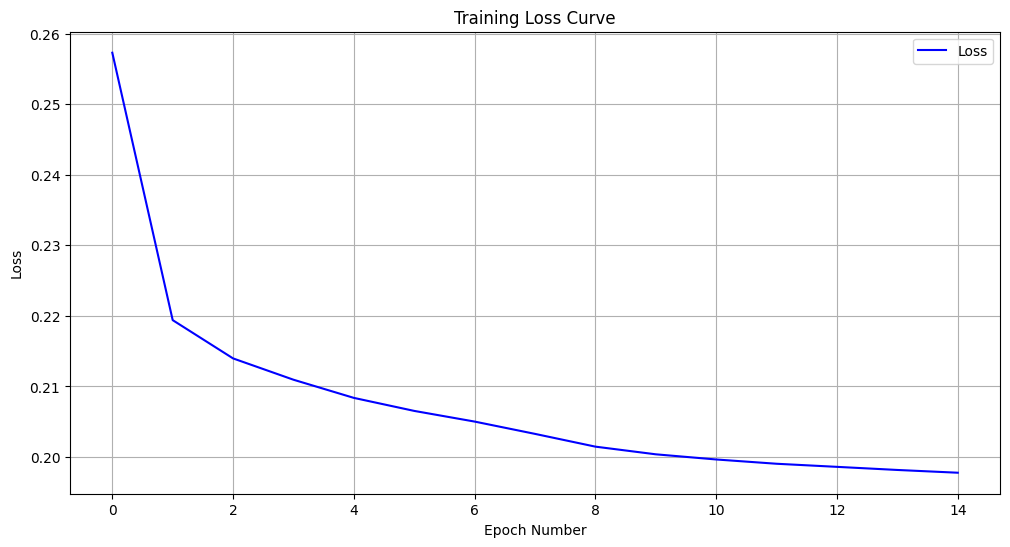


Evaluation Metrics:
Precision: 0.1743
Recall: 0.6071
F1 Score: 0.2708
ROC AUC: 0.8427
Accuracy: 0.8641

Confusion Matrix:
[[594273  84693]
 [ 11570  17874]]


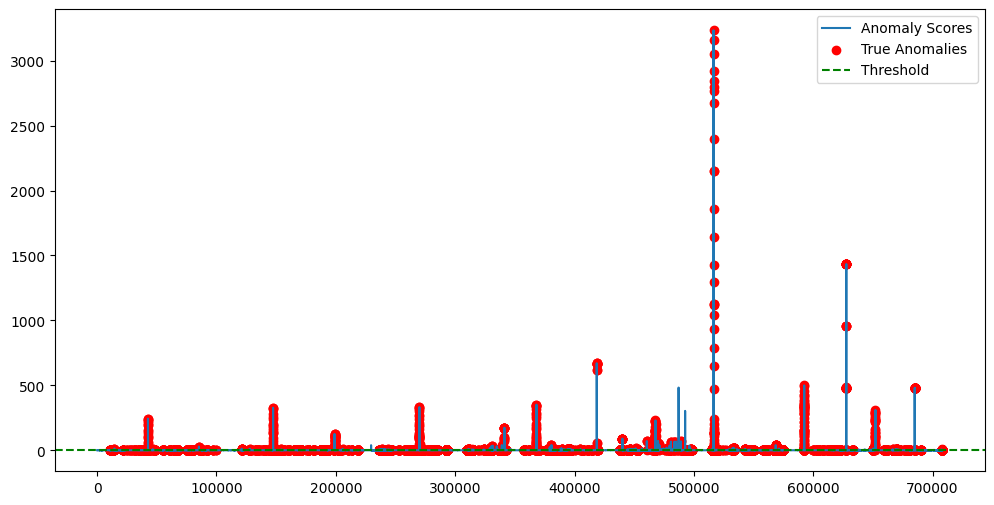

In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


train_data = np.load('/home/haoqian/anomaly/ml/fusion/fusion_train.npy')
test_data = np.load('/home/haoqian/anomaly/ml/fusion/fusion_test.npy')
test_label = np.load('/home/haoqian/anomaly/SMD/SMD_test_label.npy')

def preprocess_data(data, scaler=None):
    if scaler is None:
        scaler = StandardScaler()
        data_scaled = scaler.fit_transform(data)
    else:
        data_scaled = scaler.transform(data)
    
    df = pd.DataFrame(data_scaled)
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)
    return df.values, scaler

train_data_processed, scaler = preprocess_data(train_data)
test_data_processed, _ = preprocess_data(test_data, scaler)

window_size = 10  
def create_sequences(data, window_size=10):
    sequences = []
    for i in range(len(data)-window_size):
        sequences.append(data[i:i+window_size])
    return np.array(sequences)

X_train = create_sequences(train_data_processed, window_size)
X_test = create_sequences(test_data_processed, window_size)
y_test = test_label[window_size:]


class LightLSTMAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size=32):  
        super().__init__()
        self.encoder = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=1,  
            batch_first=True
        )
        self.decoder = nn.LSTM(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True
        )
        self.output_layer = nn.Linear(hidden_size, input_size)
        
    def forward(self, x):
        # Encoder
        _, (hidden, cell) = self.encoder(x)
        # Decoder
        output, _ = self.decoder(
            torch.zeros(x.size(0), x.size(1), hidden.size(2)).to(x.device),
            (hidden, cell)
        )
        return self.output_layer(output)

model = LightLSTMAutoencoder(input_size=X_train.shape[2]).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()


import matplotlib.pyplot as plt
from tqdm import tqdm

def train_in_batches(model, train_loader, epochs=15): 
    model.train()
    loss_values = []  
    for epoch in range(epochs):
        total_loss = 0
        for batch_x, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            optimizer.zero_grad()
            reconstructions = model(batch_x)
            loss = criterion(reconstructions, batch_x)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            del reconstructions, loss
            torch.cuda.empty_cache()
        print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")
        loss_values.append(total_loss/len(train_loader))  
    return model, loss_values

batch_size = 64  
train_dataset = TensorDataset(
    torch.FloatTensor(X_train).to(device), 
    torch.FloatTensor(X_train).to(device)
)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
model, loss_values = train_in_batches(model, train_loader)

plt.figure(figsize=(12, 6))
plt.plot(loss_values, label='Loss', color='blue')
plt.title('Training Loss Curve')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

def compute_scores_safely(model, data, batch_size=64):
    model.eval()
    scores = []
    with torch.no_grad():
        for i in range(0, len(data), batch_size):
            batch = torch.FloatTensor(data[i:i+batch_size]).to(device)
            reconstructions = model(batch)
            mse = torch.mean((batch - reconstructions)**2, dim=(1, 2))
            scores.extend(mse.cpu().numpy())
            # 及时释放内存
            del batch, reconstructions, mse
            torch.cuda.empty_cache()
    return np.array(scores)

train_scores = compute_scores_safely(model, X_train)
test_scores = compute_scores_safely(model, X_test)


threshold = np.quantile(train_scores, 0.95)
test_preds = (test_scores > threshold).astype(int)

from sklearn.metrics import recall_score

def evaluate_results(true_labels, pred_labels, anomaly_scores):
    print("\nEvaluation Metrics:")
    print(f"Precision: {precision_score(true_labels, pred_labels):.4f}")
    print(f"Recall: {recall_score(true_labels, pred_labels):.4f}")  
    print(f"F1 Score: {f1_score(true_labels, pred_labels):.4f}")
    print(f"ROC AUC: {roc_auc_score(true_labels, anomaly_scores):.4f}")
    print(f"Accuracy: {accuracy_score(true_labels, pred_labels):.4f}")
    print("\nConfusion Matrix:")
    print(confusion_matrix(true_labels, pred_labels))
    
    plt.figure(figsize=(12, 6))
    plt.plot(anomaly_scores, label='Anomaly Scores')
    plt.scatter(np.where(true_labels == 1)[0], 
                anomaly_scores[true_labels == 1], 
                color='red', label='True Anomalies')
    plt.axhline(threshold, color='g', linestyle='--', label='Threshold')
    plt.legend()
    plt.show()

evaluate_results(y_test, test_preds, test_scores)


Model weights saved to /home/haoqian/anomaly/ensamble-learning/models/light_lstm_autoencoder.pth

Evaluation Metrics:
Precision: 0.1743
Recall: 0.6071
F1 Score: 0.2708
ROC AUC: 0.8427
Accuracy: 0.8641

Confusion Matrix:
[[594273  84693]
 [ 11570  17874]]


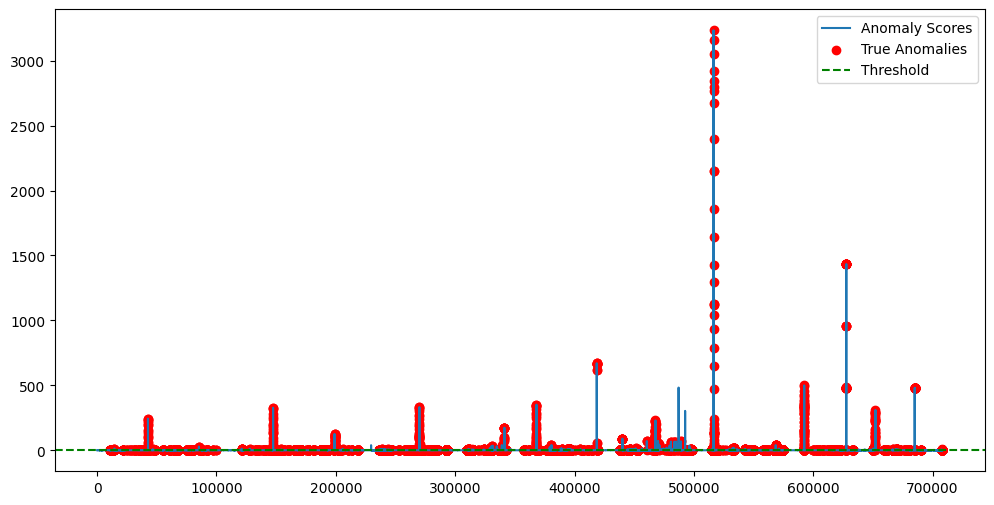

In [4]:
model_path = '/home/haoqian/anomaly/ensamble-learning/models/light_lstm_autoencoder.pth'
torch.save(model.state_dict(), model_path)
print(f"Model weights saved to {model_path}")

model_loaded = LightLSTMAutoencoder(input_size=X_train.shape[2]).to(device)

model_loaded.load_state_dict(torch.load(model_path))
model_loaded.eval()  

test_scores_loaded = compute_scores_safely(model_loaded, X_test)

threshold_loaded = np.quantile(train_scores, 0.95)  
test_preds_loaded = (test_scores_loaded > threshold_loaded).astype(int)

evaluate_results(y_test, test_preds_loaded, test_scores_loaded)

In [ ]:
np.save("/home/haoqian/anomaly/ensamble-learning/models/train_scores_lstm.npy",train_scores)